In [24]:
import os
os.chdir('..')
print(os.getcwd())

from matplotlib import pyplot as plt
from dataset import JSRTDataset, TRAINING_SHAPES
import torch
from scipy.interpolate import griddata
from torch.nn import functional as F

/home


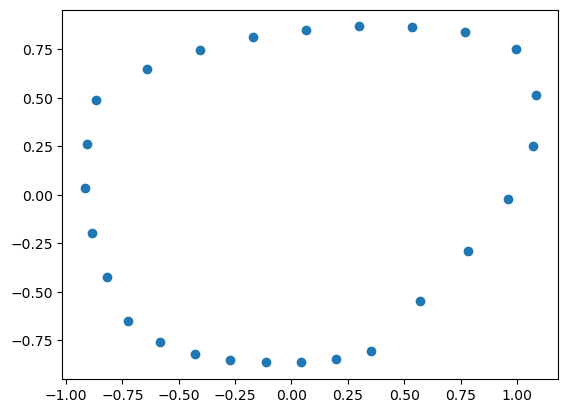

In [25]:
heart_idx = JSRTDataset.get_anatomical_structure_index()['heart']
heart_shapes = (TRAINING_SHAPES[:, heart_idx[0]:heart_idx[1]] + 1) / 2 * 256
mean_shape = heart_shapes.mean(0)
mean_shape -= mean_shape.mean(0)
mean_shape /= max(mean_shape.max(0).values - mean_shape.min(0).values)
mean_shape *= 2

del heart_shapes, heart_idx
plt.scatter(mean_shape[:, 0], mean_shape[:, 1])

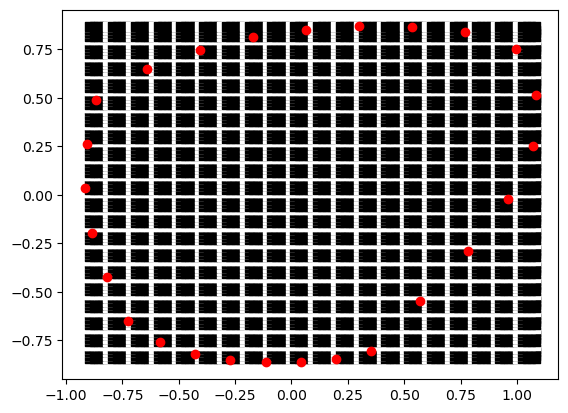

In [26]:
grid_img = torch.zeros(100, 100)
grid_img[::5, :] = 1
grid_img[:, ::5] = 1

grid_coord = torch.meshgrid(
    torch.linspace(mean_shape[:, 0].min(), mean_shape[:, 0].max(), 100),
    torch.linspace(mean_shape[:, 1].min(), mean_shape[:, 1].max(), 100),
    indexing='xy'
)
grid_coord = torch.stack(grid_coord, dim=-1)

plt.scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=grid_img.reshape(-1), cmap='gray', marker=',')
plt.scatter(mean_shape[:, 0], mean_shape[:, 1], c='r')

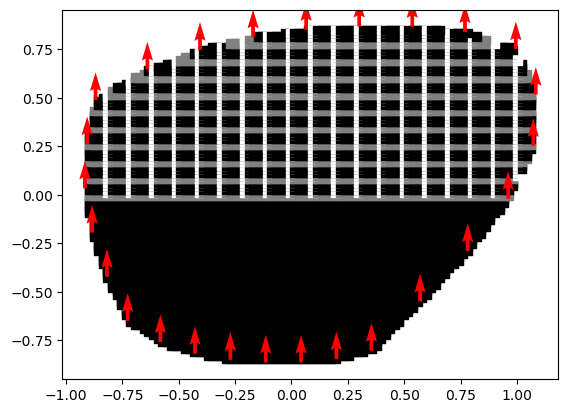

In [27]:
sample_disp = torch.ones_like(mean_shape)
sample_disp[:, 0] = 0
grid_disp = griddata(mean_shape, sample_disp, grid_coord, method='linear')
grid_disp = torch.from_numpy(grid_disp).float()

identity_grid = F.affine_grid(torch.eye(2, 3).unsqueeze(0), [1, 1, *grid_img.shape], align_corners=True)
grid = identity_grid + grid_disp.unsqueeze(0) * -1
warped_grid = F.grid_sample(grid_img.unsqueeze(0).unsqueeze(0), grid, mode='bilinear', align_corners=True)
warped_grid = warped_grid.squeeze(0).squeeze(0)
plt.scatter(grid_coord[..., 0].reshape(-1), grid_coord[..., 1].reshape(-1), c=warped_grid.reshape(-1), cmap='gray', marker=',')
plt.quiver(mean_shape[:, 0], mean_shape[:, 1], sample_disp[:, 0], sample_disp[:, 1], color='r')